In [28]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
plt.rcParams.update({'figure.max_open_warning': 0})
from astropy.io import fits
import pymc3 as pm
import pandas as pd
import exoplanet as xo
from parameters import *

In [29]:
pwd

'/Users/emilygilbert/Code/tess_k2_overlap'

In [30]:
hostname = 'K2-167'
TIC = 69747919

tess_offset, k2_offset = define_offsets()

period, t0, dur, depth, impact_param, r_planet, r_star = get_params(hostname)
period_guess, t0, dur, depth, impact_param, r_planet, r_star = generate_inputs(period, t0, dur, depth, impact_param, r_planet, r_star)


print(period_guess)

9.977481


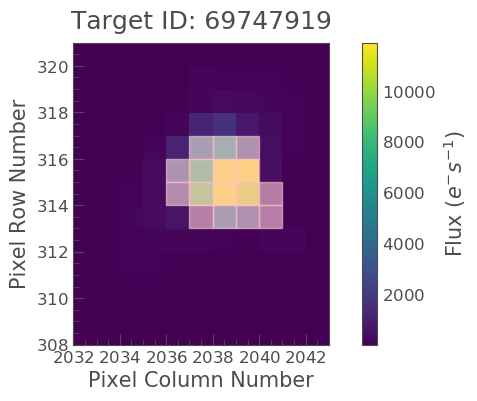

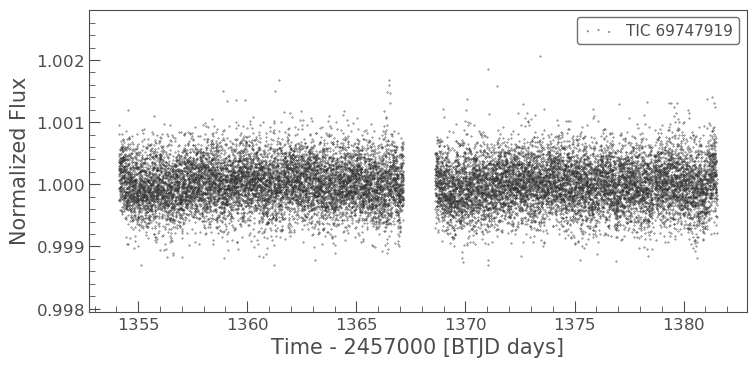

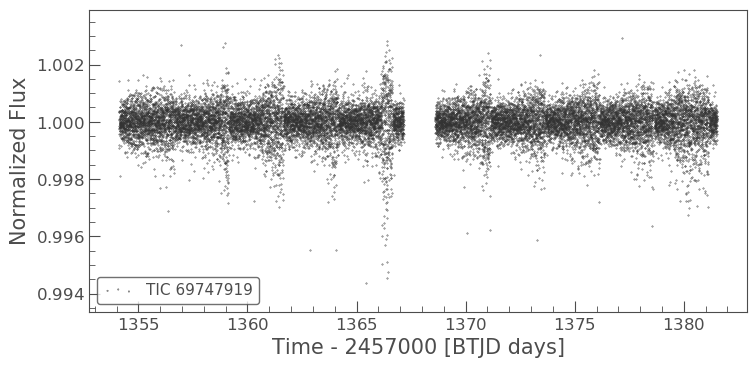

In [31]:
# known transit times for target converted to TESS time
# this will be automated eventually
t1_tess = 2458356.835732790 - 2457000
t2_tess = 2458366.812702527 - 2457000
t3_tess = 2458376.790203780 - 2457000

# plot the TPF for the target to make sure the aperture looks ok
tpf_tess = lk.search_targetpixelfile(TIC, mission='TESS').download()
tpf_tess.plot(aperture_mask=tpf_tess.pipeline_mask)
tpf_tess.interact()

# run PLD on light curve to remove noise
def get_transit_mask(t, transit_time, period_guess, duration=0.2):
    hp = 0.5*period_guess
    return np.abs((t-transit_time+hp) % period_guess - hp) < 0.5*duration

mask = np.ones_like(tpf_tess.time, dtype=bool)
mask &= get_transit_mask(tpf_tess.time, t1_tess, period_guess)
corrector = lk.PLDCorrector(tpf_tess)
lc_tess = corrector.correct(cadence_mask=~mask, use_gp=False)
lc_tess = lc_tess.remove_outliers(sigma = 6).remove_outliers(sigma=6)

# plot light curve without PLD corrections for comparison
lc2_tess = tpf_tess.to_lightcurve(aperture_mask=tpf_tess.pipeline_mask)
clipped_lc2_tess = lc2_tess.remove_outliers(sigma=6).flatten()

ax = lc_tess.scatter(s=0.1)
ax = clipped_lc2_tess.scatter(s=0.1)

In [32]:
# # plot transit times predicted by K2 on the TESS light curve
# ax = lc_tess.scatter(s=0.1)
# plt.xlim(1353,1383)

# x_tess = []
# x_tess.append(t1_tess)
# x_tess.append(t2_tess)
# x_tess.append(t3_tess)
# print(x_tess)

# for i in x_tess:
#     plt.axvline(x=i, color='hotpink', alpha=0.4, linewidth = 6)
    
# plt.title('K2-167 Light Curve') 
# plt.savefig('k2-167b.png')
# plt.show()

In [34]:
# # fold data using period determined by K2 to generate phase curve with TESS data
# fold = lc_tess.fold(period_guess, t0 = t1_tess)
# ax = fold.scatter(s=0.1)

In [35]:
# format data for use in xo
norm_tess = lc_tess.normalize()
x_tess = np.ascontiguousarray(norm_tess.time, dtype=np.float64)
y_tess = np.ascontiguousarray(norm_tess.flux, dtype=np.float64)
yerr_tess = np.ascontiguousarray(norm_tess.flux_err, dtype=np.float64)

In [7]:
# initial fit of model parameters using TESS data
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1, sd=1.0)

    # The time of a reference transit for the planet (including a manually determined offset)
    t0 = pm.Normal("t0", mu=t1_tess + 0.05, sd=1.0)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u")

    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.001, max_radius=0.1,
        testval_r=.01,
        testval_b=0.5
    )

    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.StarryLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=x_tess)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr_tess, observed=y_tess)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln_tess = model.test_point
    map_soln_tess = xo.optimize(start=map_soln_tess, vars = [t0])
    map_soln_tess = xo.optimize(start=map_soln_tess, vars = [mean, model.rb])
    map_soln_tess = xo.optimize(start=map_soln_tess, vars = [logP, t0])
    map_soln_tess = xo.optimize(start=map_soln_tess)

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['t0']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

message: Desired error not necessarily achieved due to precision loss.
logp: 119463.91532265065 -> 119499.96458791343
optimizing logp for variables: ['rb_radiusimpact__', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

message: Desired error not necessarily achieved due to precision loss.
logp: 119499.96458791343 -> 119518.42154424865
optimizing logp for variables: ['t0', 'logP']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: 119518.42154424865 -> 119518.4525654894
optimizing logp for variables: ['rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: 119518.4525654894 -> 119518.869981245


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [8]:
# display initial model results
print(map_soln_tess)

{'mean': array(1.00000905), 't0': array(1356.97977156), 'logP': array(2.30030754), 'u_quadlimbdark__': array([-0.76166891, -0.52117   ]), 'rb_radiusimpact__': array([[-0.21130305],
       [-1.89387946]]), 'period': array(9.97725035), 'u': array([0.42039296, 0.14377371]), 'rb': array([[0.01394947],
       [0.4204621 ]]), 'r': array([0.01394947]), 'b': array([0.4204621]), 'light_curves': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])}


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


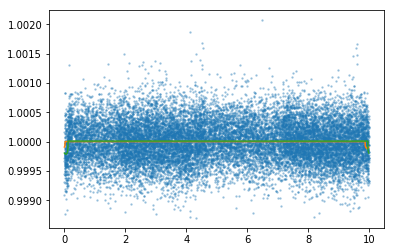

In [9]:
# plot estimated transit model over folded data
x_fold = x_tess % period_guess
inds = np.argsort(x_fold)
plt.plot(x_fold, y_tess, ".", ms=3, alpha=0.3)
with model:
    plt.plot(x_fold[inds], xo.utils.eval_in_model(light_curve)[inds])
    plt.plot(x_fold[inds], xo.utils.eval_in_model(light_curve, map_soln_tess)[inds])

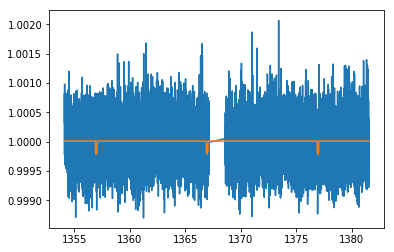

In [10]:
# plot model transits over TESS data
plt.plot(x_tess, y_tess)
plt.plot(x_tess, map_soln_tess["light_curves"] + map_soln_tess["mean"])

In [11]:
# run MCMC to determine planet parameters
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln_tess, step_kwargs=dict(target_accept=0.9))
    trace_tess = sampler.sample(draws=3000)

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains: 100%|██████████| 404/404 [00:15<00:00, 19.92draws/s]
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rb, u, logP, t0, mean]
INFO:pymc3:NUTS: [rb, u, logP, t0, mean]
Sampling 2 chains: 100%|██████████| 6000/6000 [02:48<00:00, 35.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [12]:
# display results
pm.summary(trace_tess, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,9.978164,0.006637,1.456350e-04,9.966457,9.991762,1779.353683,1.000393
t0,1356.974722,0.008910,1.838003e-04,1356.956983,1356.991765,1978.715783,0.999834
r__0,0.013520,0.000858,1.620274e-05,0.011805,0.015099,2811.496886,0.999892
b__0,0.330685,0.157677,4.187786e-03,0.005500,0.559326,1352.494676,0.999917
u__0,0.466375,0.351588,5.824328e-03,0.000254,1.155825,4293.288026,0.999855
u__1,0.151590,0.353141,5.492086e-03,-0.504996,0.828554,4605.125146,1.000155
mean,1.000009,0.000003,3.973438e-08,1.000004,1.000014,3882.600774,1.000018


In [36]:
# known transit time during K2 observation
t1_k2 = 2156.9142610001054

ColDefs(
    name = 'T'; format = 'D'
    name = 'FRAW'; format = 'D'
    name = 'FCOR'; format = 'D'
    name = 'ARCLENGTH'; format = 'D'
    name = 'MOVING'; format = 'I'
    name = 'CADENCENO'; format = 'J'
)


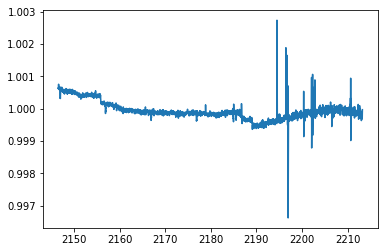

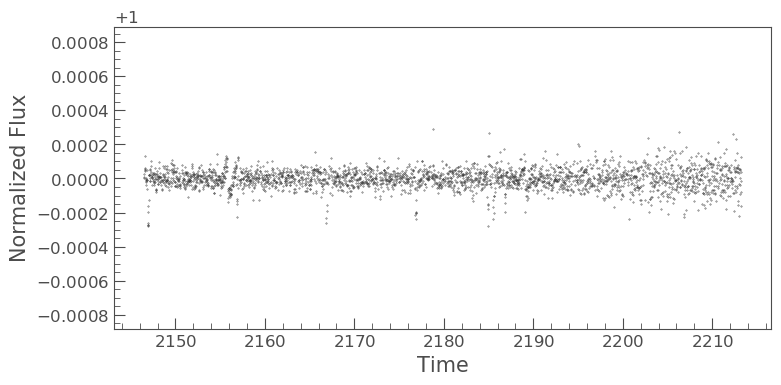

In [37]:
# read in K2 SFF data
hdu = fits.open('./c03/205900000/04628/hlsp_k2sff_k2_lightcurve_205904628-c03_kepler_v1_llc.fits')
print(hdu[1].columns)
flux = hdu[1].data['FCOR']
time = hdu[1].data['T']

# plot uncorrected light curve
plt.plot(time,flux)

# correct light curve
lc_k2 = lk.LightCurve(flux=flux, time=time)
clipped_lc_k2 = lc_k2.flatten().remove_outliers(sigma=6).remove_outliers(sigma=6)
y_err_k2 = np.std(clipped_lc_k2.flux[0:100]) * np.ones(len(clipped_lc_k2.flux))

# plot corrected light curve 
ax = clipped_lc_k2.scatter(s=0.1)

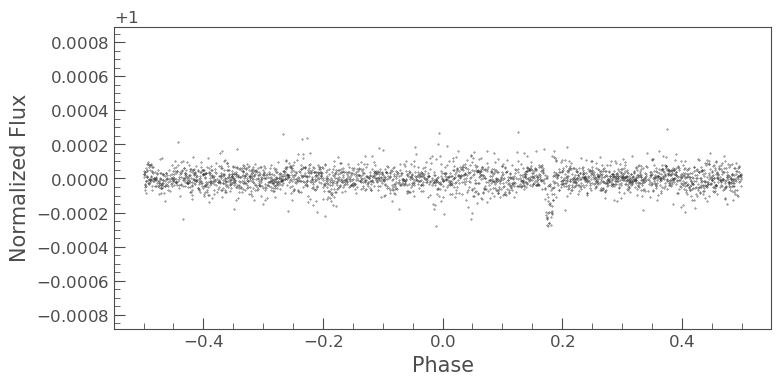

In [38]:
# plot phase curve
fold_k2 = clipped_lc_k2.fold(9.977481)
ax = fold_k2.scatter(s=0.1)

In [39]:
# format data for input into xo
norm_k2 = clipped_lc_k2.normalize()
x_k2 = np.ascontiguousarray(norm_k2.time, dtype=np.float64)
y_k2 = np.ascontiguousarray(norm_k2.flux, dtype=np.float64)
yerr_k2 = np.ascontiguousarray(y_err_k2, dtype=np.float64)

In [41]:
with pm.Model() as model:

    # The baseline flux
    mean_k2 = pm.Normal("mean_k2", mu=1, sd=1.0)
    mean_tess = pm.Normal("mean_tess", mu=1, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t1_k2, sd=1.0)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u_k2 = xo.distributions.QuadLimbDark("u_k2")
    u_tess = xo.distributions.QuadLimbDark("u_tess")

    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.0001, max_radius=0.1,
        testval_r=.001,
        testval_b=0.5
    )

    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves_k2 = xo.StarryLightCurve(u_tess).get_light_curve(
        orbit=orbit, r=r, t=x_k2)
    light_curve_k2 = pm.math.sum(light_curves_k2, axis=-1) + mean_k2
    
    
    print(len(yerr_tess), len(y_tess), len(x_tess))
    
    light_curves_tess = xo.StarryLightCurve(u_tess).get_light_curve(
        orbit=orbit, r=r, t=x_tess)
    light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves_k2", light_curves_k2)
    pm.Deterministic("light_curves_tess", light_curves_tess)


    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs_k2", mu=light_curve_k2, sd=yerr_k2, observed=y_k2)
    pm.Normal("obs_tess", mu=light_curve_tess, sd=yerr_tess, observed=y_tess)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln_k2 = model.test_point
    map_soln_k2 = xo.optimize(start=map_soln_k2, vars = [t0])
    map_soln_k2 = xo.optimize(start=map_soln_k2, vars = [mean_k2, mean_tess, model.rb])
    map_soln_k2 = xo.optimize(start=map_soln_k2, vars = [logP, t0])
    map_soln_k2 = xo.optimize(start=map_soln_k2)

18316 18316 18316
optimizing logp for variables: ['t0']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: 141800.21616518075 -> 141800.22420570513
optimizing logp for variables: ['rb_radiusimpact__', 'mean_tess', 'mean_k2']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

message: Desired error not necessarily achieved due to precision loss.
logp: 141800.22420570513 -> 141850.37081184724
optimizing logp for variables: ['t0', 'logP']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

message: Desired error not necessarily achieved due to precision loss.
logp: 141850.37081184724 -> 141861.0573795213
optimizing logp for variables: ['rb_radiusimpact__', 'u_tess_quadlimbdark__', 'u_k2_quadlimbdark__', 'logP', 't0', 'mean_tess', 'mean_k2']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

message: Desired error not necessarily achieved due to precision loss.
logp: 141861.0573795213 -> 141862.12714771487


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [42]:
# print initial model results
print(map_soln_k2)

{'mean_k2': array(1.00000101), 'mean_tess': array(1.00000762), 't0': array(2156.91693011), 'logP': array(2.29958538), 'u_k2_quadlimbdark__': array([9.79247211e-17, 0.00000000e+00]), 'u_tess_quadlimbdark__': array([-0.46609236, -0.19225289]), 'rb_radiusimpact__': array([[ 0.41621017],
       [-2.14828033]]), 'period': array(9.97004779), 'u_k2': array([0.70710678, 0.        ]), 'u_tess': array([0.56141626, 0.05950366]), 'rb': array([[0.01053875],
       [0.58278495]]), 'r': array([0.01053875]), 'b': array([0.58278495]), 'light_curves_k2': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]]), 'light_curves_tess': array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])}


In [43]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln_k2, step_kwargs=dict(target_accept=0.9))
    trace_k2 = sampler.sample(draws=3000)

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains: 100%|██████████| 404/404 [01:54<00:00,  1.35draws/s]
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rb, u_tess, u_k2, logP, t0, mean_tess, mean_k2]
INFO:pymc3:NUTS: [rb, u_tess, u_k2, logP, t0, mean_tess, mean_k2]
Sampling 2 chains: 100%|██████████| 6000/6000 [1:03:53<00:00,  1.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [59]:
# print planet parameters determined using K2 data
pm.summary(trace_k2, varnames=["period", "t0", "r", "b", "u_k2", "mean_k2","u_tess", "mean_tess"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period,9.971965,0.000960,9.377083e-05,9.970208,9.972944,7.556884,1.003129
t0,2156.919019,0.004509,1.482937e-04,2156.910665,2156.928415,252.024062,0.999963
r__0,0.010541,0.000736,3.295337e-05,0.008964,0.011861,61.597769,0.999959
b__0,0.513918,0.131616,5.981817e-03,0.195865,0.724457,91.384092,0.999899
u_k2__0,0.663600,0.477213,7.269968e-03,0.000174,1.568209,4409.840888,0.999880
u_k2__1,0.008888,0.415886,6.187015e-03,-0.777167,0.789284,4879.357369,0.999835
mean_k2,1.000001,0.000001,1.861204e-08,0.999998,1.000004,5758.019807,0.999993
u_tess__0,0.541138,0.396646,1.136841e-02,0.000019,1.302720,1257.595490,0.999990
u_tess__1,0.061203,0.358174,1.100918e-02,-0.612524,0.760333,973.027662,1.000809
mean_tess,1.000008,0.000002,3.719605e-08,1.000003,1.000013,5588.961777,1.000028


In [61]:
#tess_period = trace_tess["period"][0]
k2_period_xo = trace_k2["period"][0]

#print(tess_period, k2_period_xo)
#print(f'The difference between TESS and K2 periods each determined with xo is {(tess_period - k2_period_xo)*24*60} minutes')
#print(f'The difference between TESS and the known period value from the literature is {(tess_period - period_guess)*24*60} minutes')
print(f'The difference between the K2 period determined with xo and the known period value from the literature is {(k2_period_xo - period_guess)*24*60} minutes')

The difference between the K2 period determined with xo and the known period value from the literature is -10.135294932766499 minutes


In [62]:
### plot results from TESS ###

# Get the posterior median orbital parameters
p = np.median(trace_tess["period"][:])
t0 = np.median(trace_tess["t0"][:])

# Compute the median of posterior estimate of the contribution from
# the other planet. Then we can remove this from the data to plot
# just the planet we care about.
other = np.median(trace_tess["mean"])

# Plot the folded data
x_fold = (x_tess - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold, y_tess - other, yerr=yerr_tess, fmt=".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace_tess["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.4f} +/- {1:.4f} d".format(
    np.mean(trace_tess["period"][:]), np.std(trace_tess["period"][:]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.title("K2-167 b, TESS Data");
plt.xlim(-0.3, 0.3)

NameError: name 'trace_tess' is not defined

(-0.3, 0.3)

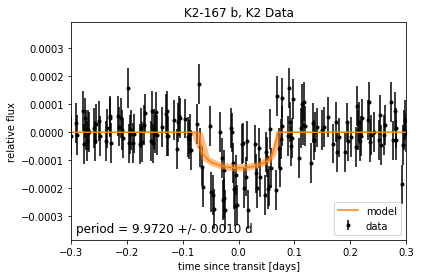

In [65]:
### plot results from K2 ###

# Get the posterior median orbital parameters
p = np.median(trace_k2["period"][:])
t0 = np.median(trace_k2["t0"][:])

# Compute the median of posterior estimate of the contribution from
# the other planet. Then we can remove this from the data to plot
# just the planet we care about.
other = np.median(trace_k2["mean_k2"])

# Plot the folded data
x_fold = (x_k2 - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold, y_k2 - other, yerr=yerr_k2, fmt=".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace_k2["light_curves_k2"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.4f} +/- {1:.4f} d".format(
    np.mean(trace_k2["period"][:]), np.std(trace_k2["period"][:]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.title("K2-167 b, K2 Data");
plt.xlim(-0.3, 0.3)